## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

2023-03-14 13:29:59.334470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [4]:
# Get to know your data
print(df.head())
print(df.shape)
print(df.dtypes)

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
(404290, 6)
id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dty

In [5]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
# Check for missing values
print(df.isna().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [7]:
# Check for duplicates
print(df.duplicated().sum())

0


In [8]:
print(df['is_duplicate'].value_counts())

0    255027
1    149263
Name: is_duplicate, dtype: int64


In [9]:
# Identify data quality issues
print(df['question1'].unique())
print(df['question2'].unique())

['What is the step by step guide to invest in share market in india?'
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?'
 'How can I increase the speed of my internet connection while using a VPN?'
 ... 'What is one coin?'
 'What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?'
 'What is like to have sex with cousin?']
['What is the step by step guide to invest in share market?'
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'
 'How can Internet speed be increased by hacking through DNS?' ...
 "What's this coin?"
 'I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?'
 'What is it like to have sex with your cousin?']


<AxesSubplot: xlabel='is_duplicate', ylabel='count'>

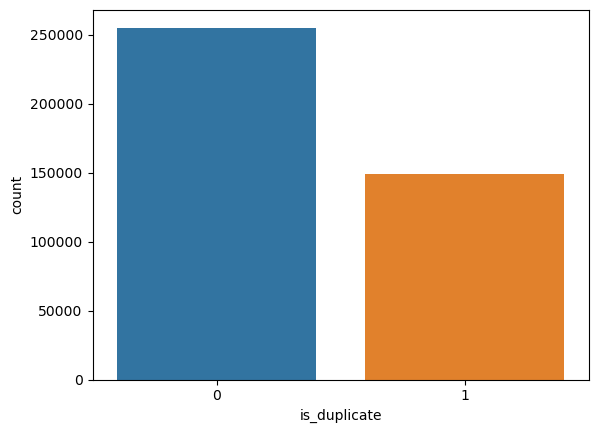

In [10]:
# Visualize the data
sns.countplot(x='is_duplicate', data=df)

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [11]:
# Handle missing values by dropping rows
df = df.dropna()

In [12]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [13]:
# Create a cleaning function
def clean_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Normalize
    tokens = [re.sub(r'\d+', '', token) for token in tokens]
    
    # Stem
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the cleaned tokens
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [14]:
# Apply the cleaning function to the question1 and question2 columns
df['question1_cleaned'] = df['question1'].apply(clean_text)
df['question2_cleaned'] = df['question2'].apply(clean_text)

# Print the cleaned data
print(df.head())

/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/34222394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['question1_cleaned'] = df['question1'].apply(clean_text)


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   
3  Find the remainder when [math]23^{24}[/math] i...             0   
4            Which fish would survive in salt water?             0   

                                   question1_cleaned  \
0           step step guid invest share market india   
1                  stori kohinoor 

/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/34222394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['question2_cleaned'] = df['question2'].apply(clean_text)


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [15]:
# Calculate the length of each question
df['q1_length'] = df['question1_cleaned'].apply(lambda x: len(x.split()))
df['q2_length'] = df['question2_cleaned'].apply(lambda x: len(x.split()))
df.head()

/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/2239849094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q1_length'] = df['question1_cleaned'].apply(lambda x: len(x.split()))
/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/2239849094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['q2_length'] = df['question2_cleaned'].apply(lambda x: len(x.split()))


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,q1_length,q2_length
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market,7,6
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor koh-i-noor diamond,would happen indian govern stole kohinoor koh-...,4,9
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dn,6,5
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mental lone solv,"find remaind math ^ /math divid ,",3,7
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,10,5


In [16]:
# Calculate the number of same words in both questions
def shared_words(row):
    q1_words = set(row['question1_cleaned'].split())
    q2_words = set(row['question2_cleaned'].split())
    return len(q1_words.intersection(q2_words))
df['shared_words'] = df.apply(shared_words, axis=1)
df.head()

/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/947231866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shared_words'] = df.apply(shared_words, axis=1)


,id,qid1,qid2,question1,question2,is_duplicate,question1_cleaned,question2_cleaned,q1_length,q2_length,shared_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guid invest share market india,step step guid invest share market,7,6,5
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,stori kohinoor koh-i-noor diamond,would happen indian govern stole kohinoor koh-...,4,9,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increas speed internet connect use vpn,internet speed increas hack dn,6,5,3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mental lone solv,"find remaind math ^ /math divid ,",3,7,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,10,5,2


In [20]:
def word2vec_embeddings(text, model):
    tokens = nltk.word_tokenize(text)
    vecs = [model.wv[word] if word in model.wv else np.zeros(model.vector_size) for word in tokens]
    return np.mean(vecs, axis=0)

# Create Word2Vec model
all_questions = pd.concat([df['question1_cleaned'], df['question2_cleaned']])
tokenized_questions = all_questions.apply(lambda x: x.split())
w2v_model = Word2Vec(tokenized_questions, min_count=1, vector_size=300)

from tqdm import tqdm
tqdm.pandas()

# Compute Word2Vec embeddings
df['w2v_q1'] = df['question1_cleaned'].progress_apply(lambda x: word2vec_embeddings(x, w2v_model))
df['w2v_q2'] = df['question2_cleaned'].progress_apply(lambda x: word2vec_embeddings(x, w2v_model))


  1%|          | 3117/404287 [00:01<01:55, 3485.55it/s]/Users/magnesium/opt/anaconda3/envs/lighthouse_labs_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████| 404287/404287 [01:27<00:00, 4628.16it/s]
/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/2955858681.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w2v_q1'] = df['question1_cleaned'].progress_apply(lambda x: word2vec_embeddings(x, w2v_model))
  2%|▏         | 6812/404287 [00:01<01:26, 4588.13it/s]/Users/magnesium/opt/anaconda3/envs/lighthouse_labs_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
 

In [21]:
# Compute tf-idf features
tfidf = TfidfVectorizer()
tfidf.fit(all_questions)
df['tfidf_q1'] = list(tfidf.transform(df['question1_cleaned']).toarray())
df['tfidf_q2'] = list(tfidf.transform(df['question2_cleaned']).toarray())

/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/1898697094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfidf_q1'] = list(tfidf.transform(df['question1_cleaned']).toarray())
/var/folders/2d/bqz04hdj23l8m45654zxfnl80000gn/T/ipykernel_38845/1898697094.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tfidf_q2'] = list(tfidf.transform(df['question2_cleaned']).toarray())


In [30]:
# Convert Word2Vec embeddings to DataFrames
w2v_q1_df = pd.DataFrame(df['w2v_q1'].apply(pd.Series))
w2v_q2_df = pd.DataFrame(df['w2v_q2'].apply(pd.Series))

# Concatenate DataFrames
X = pd.concat([w2v_q1_df, w2v_q2_df], axis=1)
y = df['is_duplicate']

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity
# Calculate the cosine similarity feature
#cosine_sim = cosine_similarity(q1_w2v, q2_w2v)

NameError: name 'q1_w2v' is not defined

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [31]:
# Split data into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
